Number of 'lie' samples: 65
Number of 'truth' samples: 78
Total number of samples: 143
Adding 5 lie samples from subject 8 to test set
Adding 6 truth samples from subject 8 to test set
Adding 5 lie samples and 6 truth samples from subject 7 to train set
Adding 5 lie samples and 6 truth samples from subject 3 to train set
Adding 5 lie samples and 6 truth samples from subject 10 to train set
Adding 5 lie samples and 6 truth samples from subject 13 to train set
Adding 5 lie samples and 6 truth samples from subject 6 to train set
Adding 5 lie samples and 6 truth samples from subject 12 to train set
Adding 5 lie samples and 6 truth samples from subject 9 to train set
Adding 5 lie samples and 6 truth samples from subject 4 to train set
Adding 5 lie samples and 6 truth samples from subject 5 to train set
Adding 5 lie samples and 6 truth samples from subject 1 to train set
Adding 5 lie samples and 6 truth samples from subject 2 to train set
Adding 5 lie samples and 6 truth samples from subject

C:\Users\User\anaconda3\envs\detectlie\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0: Train Loss: 0.6923330545425415, Validation Loss: 0.6739305257797241
Epoch 1: Train Loss: 0.686963415145874, Validation Loss: 0.6614761352539062
Epoch 2: Train Loss: 0.7412827014923096, Validation Loss: 0.6469988226890564
Epoch 3: Train Loss: 0.6600551009178162, Validation Loss: 0.6298553347587585
Epoch 4: Train Loss: 0.6549185931682586, Validation Loss: 0.6220439076423645
Epoch 5: Train Loss: 0.6586509704589844, Validation Loss: 0.6122717261314392
Epoch 6: Train Loss: 0.6600031793117523, Validation Loss: 0.6051663160324097
Epoch 7: Train Loss: 0.692110288143158, Validation Loss: 0.601341962814331
Epoch 8: Train Loss: 0.7343206167221069, Validation Loss: 0.5922523140907288
Epoch 9: Train Loss: 0.6661735415458679, Validation Loss: 0.5929101705551147
Epoch 10: Train Loss: 0.7078230142593384, Validation Loss: 0.5932563543319702
Epoch 11: Train Loss: 0.6380539238452911, Validation Loss: 0.592065691947937
Epoch 12: Train Loss: 0.6829540967941284, Validation Loss: 0.5985586643218994


C:\Users\User\anaconda3\envs\detectlie\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: Train Loss: 0.6580873727798462, Validation Loss: 0.6793584227561951
Epoch 3: Train Loss: 0.7726146936416626, Validation Loss: 0.6698598265647888
Epoch 4: Train Loss: 0.6907626390457153, Validation Loss: 0.656006395816803
Epoch 5: Train Loss: 0.6440469443798065, Validation Loss: 0.6431587934494019
Epoch 6: Train Loss: 0.634396779537201, Validation Loss: 0.6385018229484558
Epoch 7: Train Loss: 0.7010484099388122, Validation Loss: 0.6331694722175598
Epoch 8: Train Loss: 0.6388112902641296, Validation Loss: 0.6291465163230896
Epoch 9: Train Loss: 0.6433927536010742, Validation Loss: 0.6245177984237671
Epoch 10: Train Loss: 0.6549885869026184, Validation Loss: 0.6212558746337891
Epoch 11: Train Loss: 0.659087085723877, Validation Loss: 0.6235234141349792
Epoch 12: Train Loss: 0.6617623090744018, Validation Loss: 0.627937376499176
Epoch 13: Train Loss: 0.6745916962623596, Validation Loss: 0.6292227506637573
Epoch 14: Train Loss: 0.6327063560485839, Validation Loss: 0.634450614452362

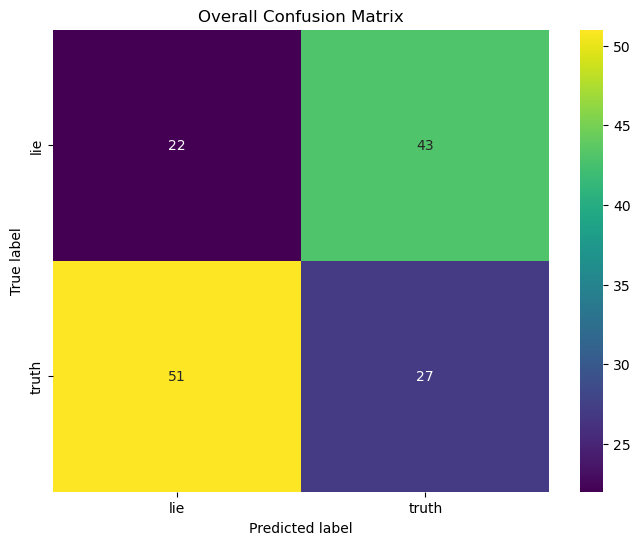

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import random
import seaborn as sns

model_save_dir = r'C:\Users\User\Documents\Lie detect data\Model'
os.makedirs(model_save_dir, exist_ok=True)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['lie', 'truth'], yticklabels=['lie', 'truth'])
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Define a function to load and pad data
def load_data(data_dir, max_length):
    subject_data = {'lie': {}, 'truth': {}}
    
    file_list = os.listdir(data_dir)
    
    for file in file_list:
        with open(os.path.join(data_dir, file), 'rb') as f:
            data = pickle.load(f)
        
        # Determine if the file is 'truth' or 'lie'
        label_type = 'truth' if 'truth' in file else 'lie'
        subj_id = int(file.split('_')[-1].split('.')[0])
        
        # Grouping logic
        if label_type == 'lie':
            # Mapping each 5 lie samples to one subject
            subject_key = (subj_id - 1) // 5 + 1
        else:  # 'truth'
            # Mapping each 6 truth samples to one subject
            subject_key = (subj_id - 1) // 6 + 1
            
        # Initialize the subject's list if it doesn't exist
        if subject_key not in subject_data[label_type]:
            subject_data[label_type][subject_key] = []
            
        # Extract only the portion of the data from time length 3000 to 3750
        data_subset = data[:, 0:250]

        # Pad or truncate the data to match max_length
        if data_subset.shape[1] > max_length:
            processed_data = data_subset[:, :max_length]  # Truncate if it exceeds max_length
        else:
            processed_data = np.zeros((data_subset.shape[0], max_length))
            processed_data[:, :data_subset.shape[1]] = data_subset  # Pad if it is shorter than max_length
        
        # Add the processed data to the appropriate list
        subject_data[label_type][subject_key].append(processed_data)
    
    return subject_data

# Load dataset and pad/truncate the data
data_dir = "C:\\Users\\User\\Documents\\Lie detect data\\7M_EEGData"
max_length = 250 # Define maximum length for padding
subject_data = load_data(data_dir, max_length)

# Count the total number of samples
num_lie_samples = sum(len(subject_data['lie'][subject_key]) for subject_key in subject_data['lie'])
num_truth_samples = sum(len(subject_data['truth'][subject_key]) for subject_key in subject_data['truth'])

print(f"Number of 'lie' samples: {num_lie_samples}")
print(f"Number of 'truth' samples: {num_truth_samples}")
print(f"Total number of samples: {num_lie_samples + num_truth_samples}")


# Define dataset class
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Ensure the data is reshaped to [1, Chans, Samples] for Conv2d input
        return torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.long)

nb_classes = 2
Chans = 65
Samples = 250
dropoutRate = 0.5 
kernLength = 125
F1 = 16
D = 2
F2 = 32

# New EEGNet Model Definition in PyTorch
class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans=65, Samples=3750,
                 dropoutRate=0.6, kernLength=125, F1=8, 
                 D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
        super(EEGNet, self).__init__()

        if dropoutType == 'SpatialDropout2D':
            dropoutLayer = nn.Dropout2d
        elif dropoutType == 'Dropout':
            dropoutLayer = nn.Dropout
        else:
            raise ValueError('dropoutType must be one of "SpatialDropout2D" or "Dropout".')

        # Block 1
        self.conv1 = nn.Conv2d(1, F1, (1, kernLength), padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        
        self.depthwiseConv = nn.Conv2d(F1, F1 * D, (Chans, 1), 
                                       groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(F1 * D)
        self.elu = nn.ELU()
        self.avgpool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = dropoutLayer(dropoutRate)

        # Block 2
        self.separableConv = nn.Sequential(
            nn.Conv2d(F1 * D, F1 * D, (1, 16), padding='same', groups=F1 * D, bias=False),
            nn.Conv2d(F1 * D, F2, (1, 1), bias=False)
        )
        self.bn3 = nn.BatchNorm2d(F2)
        self.avgpool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = dropoutLayer(dropoutRate)

        # Fully connected layer
        self.fc = nn.Linear(F2 * (Samples // (4 * 8)), nb_classes)

    def forward(self, x):
        # Input block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.depthwiseConv(x)
        x = self.bn2(x)
        x = self.elu(x)
        x = self.avgpool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.separableConv(x)
        x = self.bn3(x)
        x = self.elu(x)
        x = self.avgpool2(x)
        x = self.dropout2(x)

        # Flatten before the fully connected layer
        x = x.flatten(start_dim=1)

        # Fully connected output
        x = self.fc(x)

        return x

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_and_evaluate(train_loader, val_loader, y_train):
    # Initialize the updated EEGNet model
    model = EEGNet(nb_classes=nb_classes, Chans=Chans, Samples=Samples,
                   dropoutRate=dropoutRate, kernLength=kernLength, F1=F1, D=D, F2=F2, norm_rate=0.25, dropoutType='Dropout').to(device)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

    num_epochs = 500
    best_val_loss = float('inf')
    patience = 500
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            fold_model_path = os.path.join(model_save_dir, f'revise_model_fold_{fold_idx}.pth')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': best_val_loss,
            }, fold_model_path)
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

        print(f'Epoch {epoch}: Train Loss: {avg_train_loss}, Validation Loss: {val_loss}')

    return model

# Set a random seed for reproducibility
random.seed(42)

# Initialize the cross-validation
subject_ids = list(range(1, 14))  # Since there are 13 subjects for lie and truth
random.shuffle(subject_ids)  # Shuffle to ensure random selection

# Initialize arrays to store all labels, predictions, and metrics
all_labels = []
all_predictions = []

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_aucs = []
fold_conf_matrices = []

for fold_idx in range(13):
    # Split subjects into test and training sets
    test_subject = subject_ids[fold_idx]

    # Prepare training and test data
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for subject_id in subject_ids:
        lie_samples = subject_data['lie'].get(subject_id, [])
        truth_samples = subject_data['truth'].get(subject_id, [])

        if subject_id == test_subject:
            X_test.extend(lie_samples)
            y_test.extend([0] * len(lie_samples))
            print(f"Adding {len(lie_samples)} lie samples from subject {subject_id} to test set")
            X_test.extend(truth_samples)
            y_test.extend([1] * len(truth_samples))
            print(f"Adding {len(truth_samples)} truth samples from subject {subject_id} to test set")
        else:
            X_train.extend(lie_samples)
            y_train.extend([0] * len(lie_samples))
            X_train.extend(truth_samples)
            y_train.extend([1] * len(truth_samples))
            print(f"Adding {len(lie_samples)} lie samples and {len(truth_samples)} truth samples from subject {subject_id} to train set")

    print(f"Total training samples: {len(X_train)}, Total test samples: {len(X_test)}")
    
    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Normalize data using scaler fitted on training data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))
    X_train = X_train.reshape(-1, 65, max_length)
    X_test = X_test.reshape(-1, 65, max_length)

    print(X_test.shape)
    print(X_train.shape)

    # Save the scaler to a file
    with open(r'C:\Users\User\Documents\Lie detect data\Model\RevisedEEGNet_scaler_{}.pkl'.format(fold_idx), 'wb') as f:
        pickle.dump(scaler, f)

    # Create datasets and dataloaders
    train_dataset = EEGDataset(X_train, y_train)
    test_dataset = EEGDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train and evaluate the model
    model = train_and_evaluate(train_loader, test_loader, y_train)

    # Evaluate on the test set and calculate metrics
    model.eval()
    fold_labels = []
    fold_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            fold_labels.extend(y_batch.cpu().numpy())
            fold_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics for the current fold
    accuracy = accuracy_score(fold_labels, fold_predictions)
    precision = precision_score(fold_labels, fold_predictions)
    recall = recall_score(fold_labels, fold_predictions)
    f1 = f1_score(fold_labels, fold_predictions)
    auc = roc_auc_score(fold_labels, fold_predictions)
    conf_matrix = confusion_matrix(fold_labels, fold_predictions)

    # Store fold metrics
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_aucs.append(auc)
    fold_conf_matrices.append(conf_matrix)

    # Print metrics for the current fold
    print(f'Fold {fold_idx + 1} Metrics:')
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}, AUC: {auc}')
    print('Confusion Matrix:')
    print(conf_matrix)

    # Aggregate all labels and predictions for final evaluation across all folds
    all_labels.extend(fold_labels)
    all_predictions.extend(fold_predictions)

    print(f'Completed fold {fold_idx + 1}')
    print('-' * 50)

# Calculate overall metrics across all folds
overall_accuracy = accuracy_score(all_labels, all_predictions)
overall_precision = precision_score(all_labels, all_predictions)
overall_recall = recall_score(all_labels, all_predictions)
overall_f1 = f1_score(all_labels, all_predictions)
overall_auc = roc_auc_score(all_labels, all_predictions)
overall_conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Overall Metrics:')
print(f'Accuracy: {overall_accuracy}, Precision: {overall_precision}, Recall: {overall_recall}, F1-score: {overall_f1}, AUC: {overall_auc}')
print('Overall Confusion Matrix:')
print(overall_conf_matrix)

plot_confusion_matrix(overall_conf_matrix, title='Overall Confusion Matrix')
